In [1]:
from cellmech import *
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# open microfscopic image of cell and convert it into matrix
image_matrix = np.array(Image.open('images/cell_boundary/img5.png').convert('L'))
image_dim = np.shape(image_matrix)

# define all the parameters that are required to calculata traction forces
cellmechparams = CellMechParameters({
    "p" : 0.5,
    "E" : 10e3,
    "pi" : np.pi,
    "N" : 20,
    "width" :2,
    "pixel_size" : 1e-7 
})

'''
first we will a dummy force field using known function (symmetric gausian) to calcualte displacement field, then we will 
use generated dispclement field to retrieve original force field so see if calculations match 
'''

force_points, updated_image = detect_shapes(image_matrix, detection_threshold = 0.5)

np.save('force_points.npy', np.array(force_points))
saved = np.load('force_points.npy')
# calculation of force field using gaussian
force_field  = calculate_dummy_force(force_points, cellmechparams)

x_axis = np.linspace(-1, 1, updated_image.shape[0])
y_axis = np.linspace(-1, 1, updated_image.shape[1])

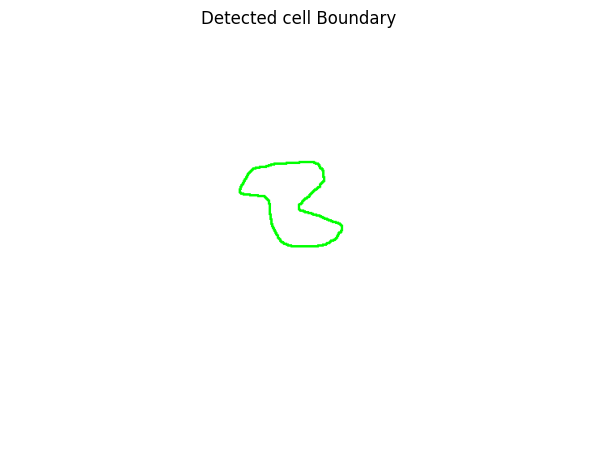

Text(0.5, 1.0, 'Cell boundary and force points')

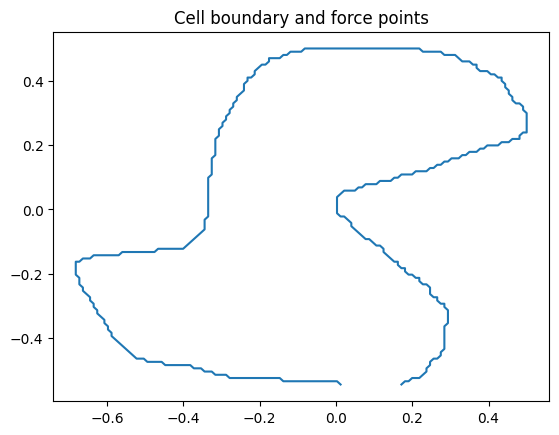

In [2]:
plot_results(updated_image)
plt.plot(force_points[:,0], force_points[:,1])
plt.title("Cell boundary and force points")

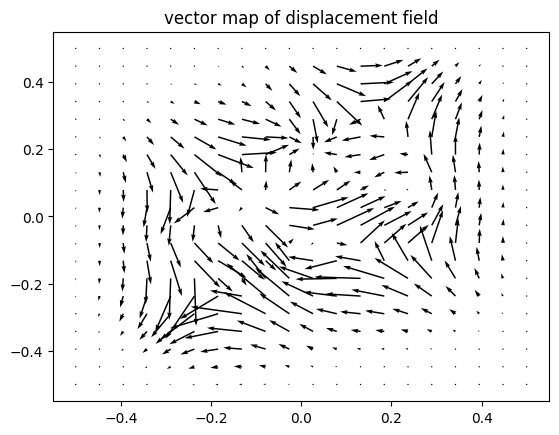

In [3]:
# calculation of displacement using FTTC and tensor network contraction
displacement = calcualte_displacement(force_field, cellmechparams, "tn")

fig = plot_vector_field(displacement, "vector map of displacement field")

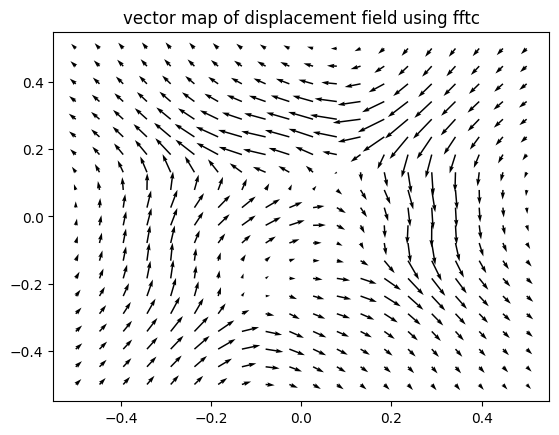

In [4]:
displacement = calcualte_displacement(force_field, cellmechparams)
fig = plot_vector_field(displacement, "vector map of displacement field using fftc")

Text(0.5, 1.0, 'Absolute displacement')

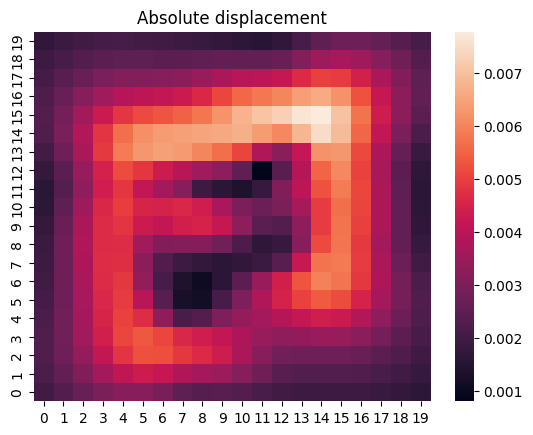

In [5]:

ax = sns.heatmap(np.sqrt(displacement[:,:,0]**2 + displacement[:,:,1]**2))
ax.invert_yaxis()
plt.title("Absolute displacement")

/mnt/c/Users/saras/Python/cellmech/cellmech/mechanics.py:233: RuntimeWarning: invalid value encountered in multiply
  G12 = coeff * (poisson_ratio * (kx * ky / k_mag**2))
/mnt/c/Users/saras/Python/cellmech/cellmech/mechanics.py:247: RuntimeWarning: invalid value encountered in multiply
  FT_Fx = ((G11 * FT_Ux + G21 * FT_Uy) * (G22**2 + G21**2 + reg_param**2) -
/mnt/c/Users/saras/Python/cellmech/cellmech/mechanics.py:248: RuntimeWarning: invalid value encountered in multiply
  (G12 * FT_Ux + G22 * FT_Uy) * (G11*G21 + G12*G22)) / det
/mnt/c/Users/saras/Python/cellmech/cellmech/mechanics.py:247: RuntimeWarning: invalid value encountered in divide
  FT_Fx = ((G11 * FT_Ux + G21 * FT_Uy) * (G22**2 + G21**2 + reg_param**2) -
/mnt/c/Users/saras/Python/cellmech/cellmech/mechanics.py:250: RuntimeWarning: invalid value encountered in multiply
  FT_Fy = ((G12 * FT_Ux + G22 * FT_Uy) * (G11**2 + G12**2 + reg_param**2) -
/mnt/c/Users/saras/Python/cellmech/cellmech/mechanics.py:251: RuntimeWarning: in

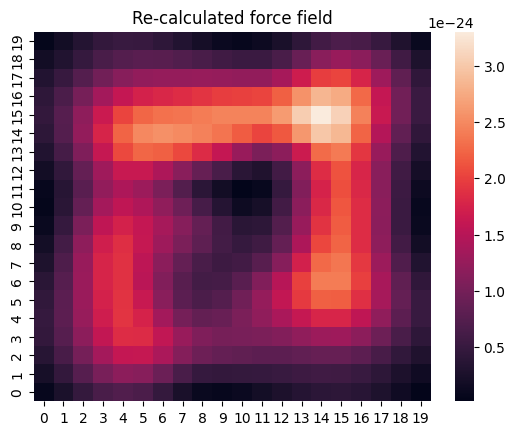

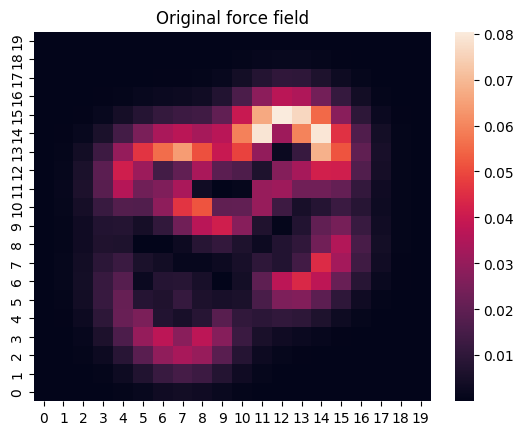

percentage error :  2222.6923906785732 %


In [6]:
'''
Now to back calculate force field from displacement field
'''

recalc_force_field = calculate_traction_force(displacement, cellmechparams)

ax = sns.heatmap(recalc_force_field[:,:,0]**2 + recalc_force_field[:,:,1]**2)
ax.invert_yaxis()
plt.title("Re-calculated force field")
plt.show()

force_field_mag = force_field[:,:,0]**2 + force_field[:,:,1]**2
recalc_force_field_mag = recalc_force_field[:,:,0]**2 + recalc_force_field[:,:,1]**2

ax = sns.heatmap(force_field[:,:,0]**2 + force_field[:,:,1]**2)
ax.invert_yaxis()
plt.title("Original force field")
plt.show()

#  re-scaling of force magnitude values (note the denominator is same for both re-calculated and original)
force_field_max_mag = np.max(force_field_mag)
force_field_mag = force_field_mag/force_field_max_mag
recalc_force_field_mag = recalc_force_field_mag/force_field_max_mag
np.save('force_field.npy', force_field_mag)
print("percentage error : ", 100*np.sum((force_field_mag - recalc_force_field_mag)**2), "%")